In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd

from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#below kinda replaces 'target_1d' above
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Subtracting Instrument Noise


In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on

flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)   
header = atlasfiles[0].header    
    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))

print('specs is the inst. noise subtracted group of files with data from target ')

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5
specs is the inst. noise subtracted group of files with data from target 


# Creating Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


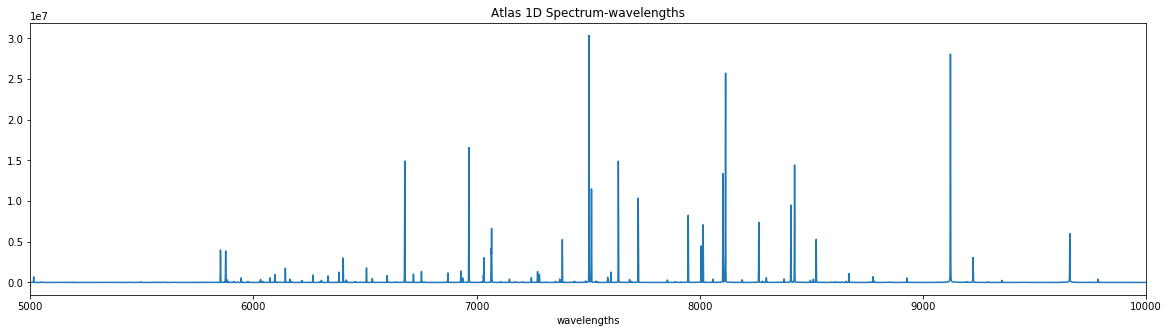

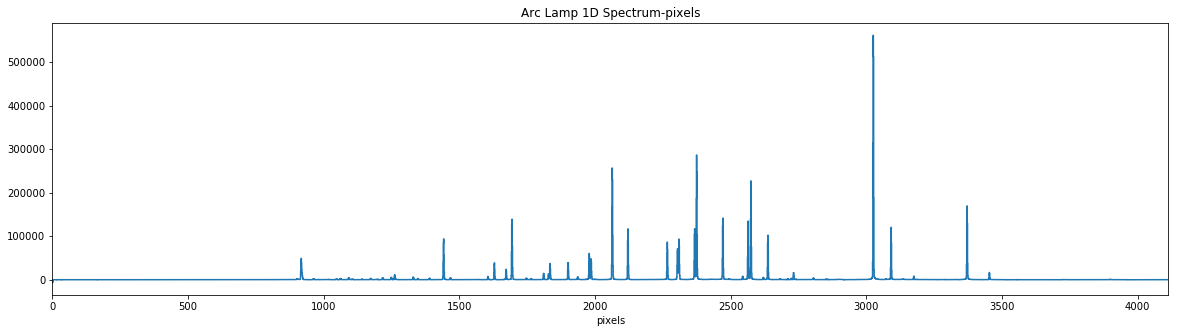

In [4]:
#creating a ds _ part one

#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = pipeline.dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,flatid)

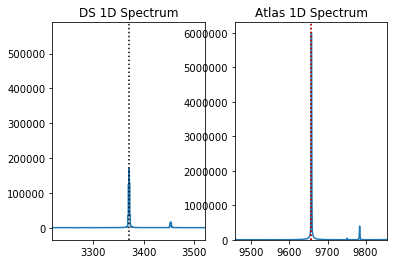

In [5]:
#creating a ds _ part two


#collecting guesses of matching lines from above graphs
#entering (px,wl)guesses & data
pipeline.guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Guessed line's peak to base ratio is 0.9423511275390428, which is less than 10"
Found line ArI at wl=8264.5225
Clipped 0 lines
Failed to find line KrI at wl=8281.0495: "Guessed line's peak to base ratio is 0.9588258798377841, which is less than 10"
Failed to find line NeI at wl=8377.6065: "Guessed line's peak to base ratio is 9.895947290981596, which is less than 10"
Found line ArI at wl=8408.2096
Clipped 0 lines
Found line ArI at wl=8424.6475
Clipped 0 lines
Failed to find line NeI at wl=8495.3598: "Guessed line's peak to base ratio is 8.92091474828603, which is less than 10"
Failed to find line KrI at wl=8508.87: "Tried to find peak at 2628.6775759657976 but it's in a valley, not a peak"
Found line ArI at wl=8521.4422
Clipped 1 lines
Failed to find line NeI at wl=8591.2583: "Guessed line's peak to base ratio is 3.615757154559494, which is less than 10

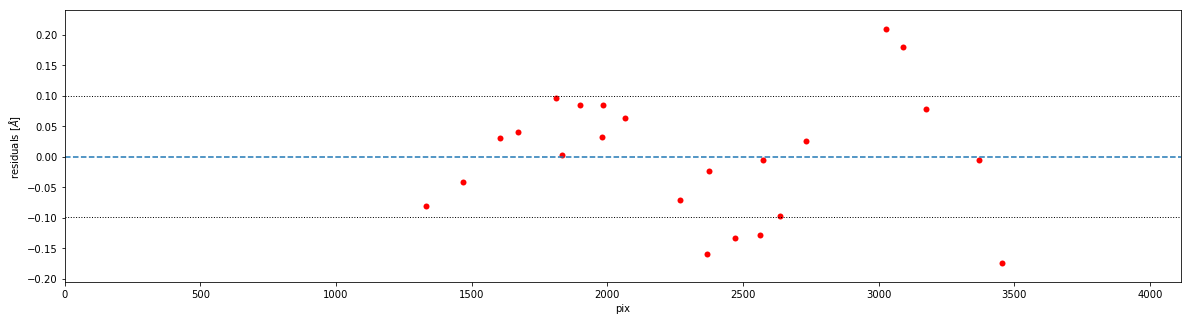

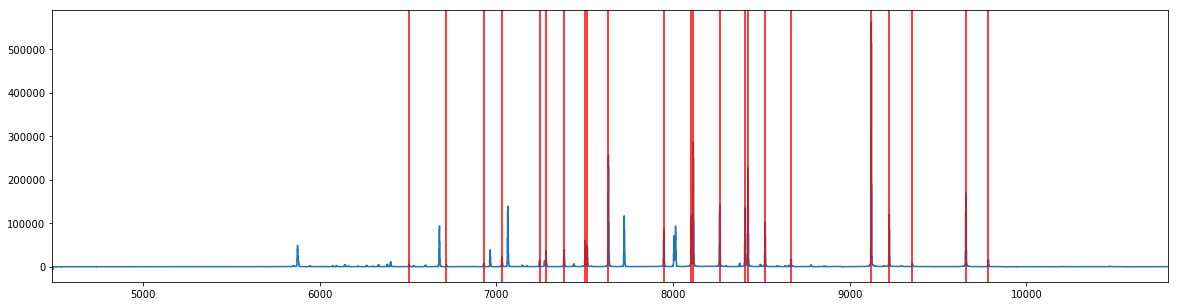

In [6]:
#creating a ds _ part three
ds_red10 = pipeline.goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid);

#this is the final ds to apply to catch22 data for this entire nb

# Sky Subtraction & stacking - data still 2D

In [7]:
#stacking all those instrument-noise-subtracted target data files-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

# Extracting 2D target spectrum (reducing spatial parameters)


FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)
NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


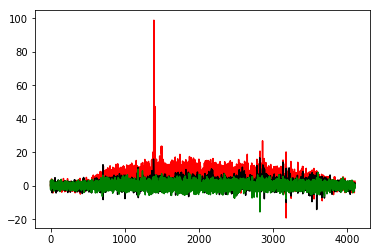

In [8]:
#first need to get 1D spectrum for each spatial pixel row in the 2D target data

#extracting target spec from whole 2d spec
target_aperature=(35,260) #target location

flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 

#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #this wont affect spatial axes pix values, only amount of flux but thats negligible


plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

# Continnum Subtraction for Entire Target

shape new: (226, 4104)
new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array


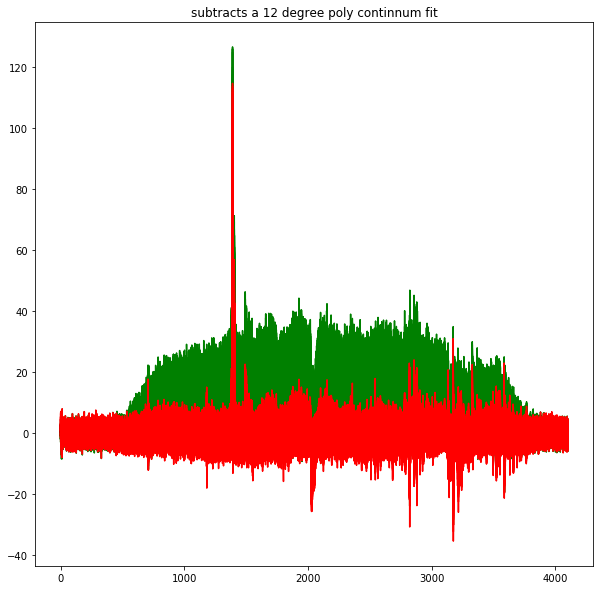

In [9]:
#good
#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
new = []


for row in flux_data: #i isnt indiv data its each spatial row of data
    xpix = np.arange(0,len(row),1) #lists pixels by index
    polydeg = 12 #what degree of line to fit to continnum
    poly = np.poly1d(np.polyfit(xpix,row, polydeg)) #this determines the fit of the continum
    spec_subtracted = row - poly(xpix)
    new.append(spec_subtracted)
new = np.array(new)

divide = 4104 #number of spectral pixels in target data 
amtofrows = int(len(new)/divide) #also ensured int not float
plt.figure(figsize=(10,10))

print('shape new:',np.shape(new))

plt.plot(flux_data.T, color='g'); #original data
plt.plot(new.T,color='r'); #continum subtracted data
plt.title('subtracts a {:} degree poly continnum fit'.format(polydeg))

print('new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array')



### Determining H-alpha wl range

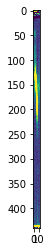

In [10]:
#determining better halpha range

#plt.figure(figsize=(2,15))

#using FULL ccd pix range
testingthis=subimg2.data[:,1396:1409]
vmin=-10
vmax=45
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
#plt.ylim(50,250)
#plt.xlim(1380, 1400)

#conclusions
ha_range_fullccd = (1396, 1409)
harange_if10missing = flux_data[:,1386:1399] #flux_data off by 10 so subtract 10 from usual h-alpha's wl-in-pixspace range 



# SANITY CHECK

new blue dot 3.39748863486 0.0
old blue dot 4.37653605687 0.0
This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason 


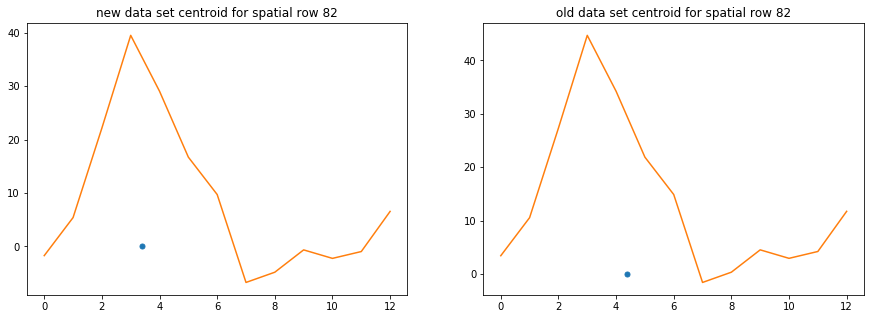

In [11]:
#new data centroiding
#ha_range_fullccd = (1396, 1409) #for reference
flux_data_short2 = flux_data[:,1386:1399] #still guessing - need convert pix to wl here somehow
new_short = new[:,1386:1399] #still guessing - need convert pix to wl here somehow, used to be 1387:1400
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho

row = 82 #change spatial row viewing here
#62, 27, 222 bad
#82, 122, 182 good


#new continum subt data
new_testha = new_short[row]
new_testha2 = new_testha[np.newaxis,:]
x2,y2 = centroid_com(new_testha2)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(x2,y2,'.',markersize=10)
ax1.plot(new_testha);
ax1.set_title('new data set centroid for spatial row {:}'.format(row))


#original data from above bad sanity check just replotting for comparison here
testha = flux_data_short2[row] #gets weird near end of range 0-226
testnewha = testha[np.newaxis,:] #converting 1d array into a 'fake' 2d array 
x,y = centroid_com(testnewha) #centroiding fcn requires 2d array input
ax2.plot(x,y,'.',markersize=10)
ax2.plot(testha);
ax2.set_title('old data set centroid for spatial row {:}'.format(row))
print('new blue dot',x2,y2)
print('old blue dot',x,y)
print('This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason ')

# Getting Galaxy Core to Center Rot. Curve around
### First Making 1D Spectrum


shape (226, 1)
x: 0.0 y: 117.150852463 y is the spatial core location still in pixels & in the Reduced spectral range
to get full plate scale pix value add 35 and 10 from 1D spec cut due to oscillations
GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL: 152.150852463
SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!
double check corrections after decide about 10 pix cut around ln[8]


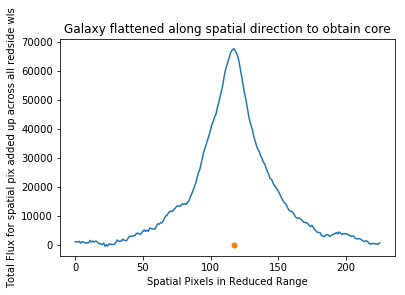

In [12]:
#USING FULL CCD SPECTRUM
#hack way of doing without a nice function from 1st cell

#flattening to be along spatial direction (histogram like)
flux_array = np.sum(flux_data,axis=1) #explicitly making an array
flux_array2d = flux_array[:, np.newaxis] #need 2d for centroiding


print('shape',np.shape(flux_array2d))
x_galcore, y_galcore = centroid_com(flux_array2d) #actually doing the centroiding

#plotting
plt.plot(flux_array2d);
plt.plot(y_galcore, x_galcore ,'.',markersize=10)
plt.xlabel('Spatial Pixels in Reduced Range')
plt.ylabel('Total Flux for spatial pix added up across all redside wls')
plt.title('Galaxy flattened along spatial direction to obtain core')

#below is amt of pix to add to target pix value to get matching plate pix #doesnt help total len tho
space_pix_correction = target_aperature[0] #from ln[9] in 1d target extract; maybe need to do this->#10 from pix cut from oscill in 1D
spatial_core_pix = y_galcore + space_pix_correction #(adds 35 to correct from target extraction),(10 from oscillations doesnt affect this b/c of spectral collapse in sum)

#conclusions
print('x:',x_galcore,'y:',y_galcore, 'y is the spatial core location still in pixels & in the Reduced spectral range')
print('to get full plate scale pix value add {:} and 10 from 1D spec cut due to oscillations'.format(target_aperature[0]))
print('GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL:',spatial_core_pix)
print('SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!')
print('double check corrections after decide about 10 pix cut around ln[8]')

shape of first section: (226, 50) matches shape of second section: (226, 50)
shape of first section 2d: (226, 1)
shape of second section 2d: (226, 1)
first section centroid x,y: 0.0 119.585965541
second section centroid x,y: 0.0 119.823579711
This is the average pixel value of the core BEFORE spatial cutout corrections 119.704772626
Pixel Value of core along spatial axis wrt full CCD size 154.704772626


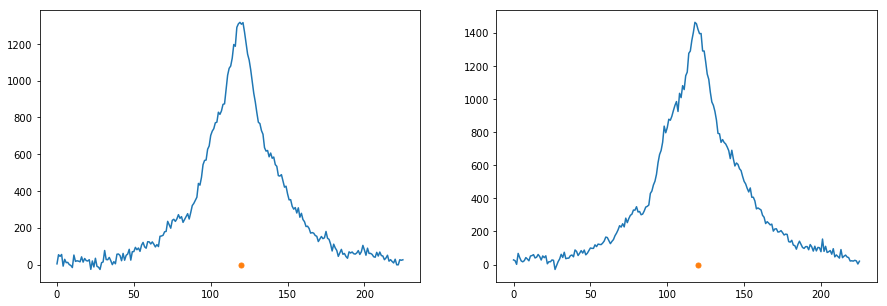

In [13]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
np.shape(flux_data)#(226,4104) #note that this is missing those 10 wl's
#also note flux_data is continuum subtracted

#below for reference
#harange_if10missing = flux_data[:,1386:1399] #flux_data off by 10 so subtract 10 from usual h-alpha's wl-in-pixspace range 
#plt.plot(harange_if10missing[11]); #saw clear ha peak so good

#making arrays surrounding h-alpha
upperha = 1399
lowerha = 1386
width_sections = 50
upper_one = lowerha - 1 #just to give it some distance
lower_one = upper_one - width_sections
lower_two = upperha + 1 #needed more distance (near&below core H-alpha leaks into this range so IF change ha range then make this 5 a 1 )
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))
#plt.plot(second_section[120]); #tried many diff row values for both sections here - satisified correct


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
x_first, y_first = centroid_com(first_section2d)
x_second, y_second = centroid_com(second_section2d)
print('first section centroid x,y:',x_first,y_first)
print('second section centroid x,y:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE spatial cutout corrections',core_avgcentroids)

#corrections to pixel value of avg section core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)



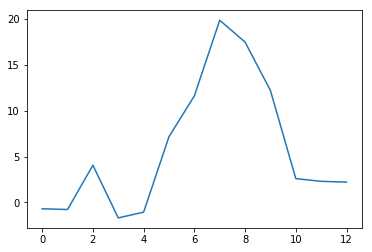

In [14]:
plt.plot(flux_data[193,1386:1399]);

# H-alpha Centroids for Entire Target


wl_pix_corrected defined here
len 226 <class 'numpy.ndarray'> (226,)
len 226 <class 'numpy.ndarray'> (226,)


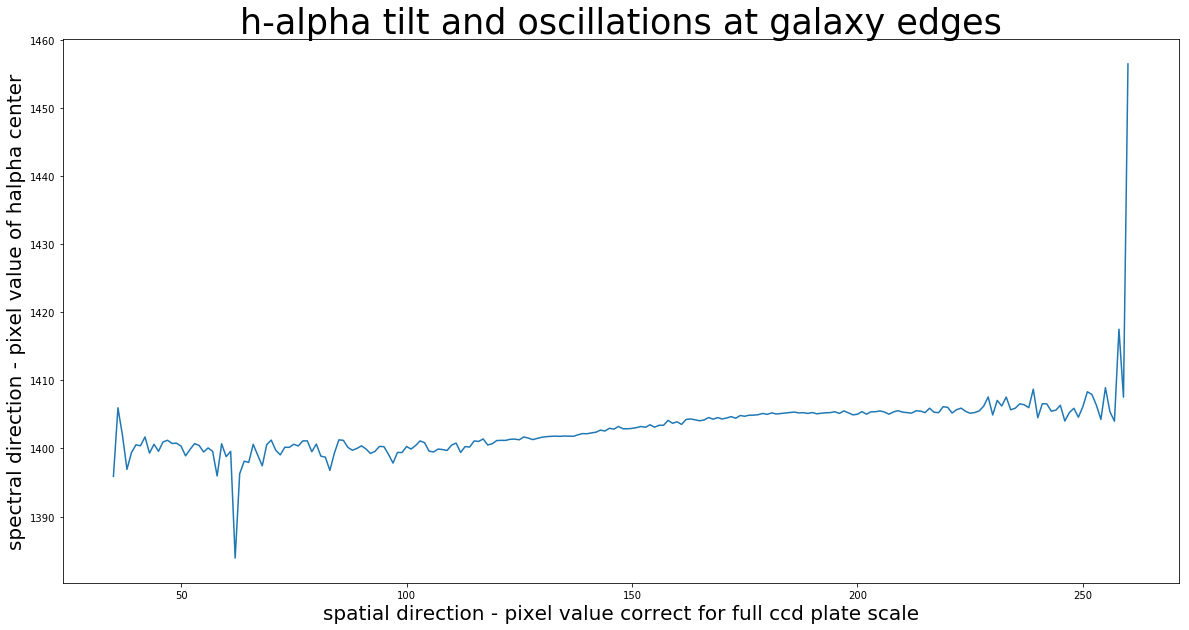

In [15]:
#good
#gets h-alpha centroid values for every spatial row within the target range 


from scipy.optimize import curve_fit
from scipy import asarray as ar,exp



#below for reference, uses full ccd wl range - first defined when applied DS
wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))
wl_shorter2 = wl[1396:1409] #isolate wl around h-alpha using full ccd plate wl range formerly 1387:1400


errors = []
mylist2 = []
mylist_ys2 = []
holding2 = []
ha_wls2 = []
##below for reference- new is continuum subst target flux data (flux_data has 10 wl cut)
#concerned 10 wl cut means 10 flux cut too in the lenght of the data but cant decide
#if the 10 is already accounted for by +1387 or should also add into space_pix_correction2
#b/c that 10 cut cutout those wl's and corresponding fluxes
##new_short = new[:,1386:1399] #cut to isolate wl around h-alpha

#gets halpha centroids in target gal's range
for row in new_short:
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    #print('row?',flux_fake2d)
    mylist4, mylist5 = centroid_com(flux_fake2d2)#finds center(x,y) of halpha for each row array
    #print(mylist4, mylist5)
    holding_arr2 = row, wl_shorter2
    x = np.array([row,wl_shorter2])
    mylist_ys2.append(mylist5)
    mylist2.append(mylist4) #collects all halpha centers per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    g_init = models.Gaussian1D(amplitude=max(y), mean=0, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    errors.append(gaussian)
    #n = len(x)                          
    #mean = sum(x*y)/n                   
    #sigma = sum(y*(x-mean)**2)/n        

    #def gaus(x,a,x0,sigma):
    #    return a*exp(-(x-x0)**2/(2*sigma**2))

    #popt,pcov = curve_fit(gaus,row,y,p0=[1,mean,sigma])
    #print(popt, pcov)
    #err = gaus(x *popt)
    #errors.append(popt)
errors = np.array(errors)    
mylist2=np.array(mylist2) #halpha centroids (wl) array

#correction for target wl pix's to match index of full ccd plate pix's (still not correct len but dont care about below target pixs-no data there neway)
wl_pix_corrected = mylist2 + wl_pix_correction + 1388 #decide how to better automate/track this
print('wl_pix_corrected defined here')
#dont have to account for osciallations b/c used full ccd plate range b4 wl cut 4 h-alpha isolation
space_pix_correction2 = np.arange(len(mylist2)) + space_pix_correction

print('len',len(mylist2),type(mylist2), np.shape(mylist2))
print('len',len(space_pix_correction2),type(space_pix_correction2), np.shape(space_pix_correction2))
#print(errors[1])
 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(space_pix_correction2,wl_pix_corrected)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha tilt and oscillations at galaxy edges',fontsize=35)
#plt.ylim(-1,10)

# Sanity Check of Errors

In [16]:
errors[0].amplitude
errors[0].fwhm

0.58309050570989562

In [17]:
#testing if errors fit a gaussian
'''
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

#print(len(errors)) #226 rows of 3 tuples
xdata = ar(len(new_short[126])) #np.linspace(0, len(new_short[5]), 50)
plt.plot(new_short[126], 'b-')
plt.plot(xdata, func(xdata, *errors[126]), 'g--')
'''

"\ndef func(x, a, b, c):\n    return a * np.exp(-b * x) + c\n\n#print(len(errors)) #226 rows of 3 tuples\nxdata = ar(len(new_short[126])) #np.linspace(0, len(new_short[5]), 50)\nplt.plot(new_short[126], 'b-')\nplt.plot(xdata, func(xdata, *errors[126]), 'g--')\n"

In [18]:
#example from stackoverflow
'''
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = ar(range(10)) #len of each row
y = ar([0,1,2,3,4,5,4,3,2,1]) #row

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
'''

"\nfrom scipy.optimize import curve_fit\nfrom scipy import asarray as ar,exp\n\nx = ar(range(10)) #len of each row\ny = ar([0,1,2,3,4,5,4,3,2,1]) #row\n\nn = len(x)                          #the number of data\nmean = sum(x*y)/n                   #note this correction\nsigma = sum(y*(x-mean)**2)/n        #note this correction\n\ndef gaus(x,a,x0,sigma):\n    return a*exp(-(x-x0)**2/(2*sigma**2))\n\npopt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])\n\nplt.plot(x,y,'b+:',label='data')\nplt.plot(x,gaus(x,*popt),'ro:',label='fit')\nplt.legend()\n"

In [19]:
#new try
'''
from astropy.modeling import models
g = models.Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5)
x = ar(range(len(new_short[162]))) #independent data, space axis
y = new_short[162] #dependent data, flux values at space points
#x = np.arange(0,len(y))

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp


n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n
popt,pcov = curve_fit(g,x,y,p0=[1,mean,sigma])

plt.plot(x,y,'b+:',label='data')
plt.plot(x,g(x,*popt),'ro:',label='fit')
plt.legend()
'''

"\nfrom astropy.modeling import models\ng = models.Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5)\nx = ar(range(len(new_short[162]))) #independent data, space axis\ny = new_short[162] #dependent data, flux values at space points\n#x = np.arange(0,len(y))\n\nfrom scipy.optimize import curve_fit\nfrom scipy import asarray as ar,exp\n\n\nn = len(x)                          #the number of data\nmean = sum(x*y)/n                   #note this correction\nsigma = sum(y*(x-mean)**2)/n\npopt,pcov = curve_fit(g,x,y,p0=[1,mean,sigma])\n\nplt.plot(x,y,'b+:',label='data')\nplt.plot(x,g(x,*popt),'ro:',label='fit')\nplt.legend()\n"

In [20]:
''' 
#very odd....works for rows 206, 26 but not for 126 or anywhere near core, just get flat lines
#another try
x = ar(range(len(new_short[162]))) #independent data, space axis
y = new_short[162] #dependent data, flux values at space points
#x = np.arange(0,len(y))

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp


n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
print('popt', popt)
print('pcov',pcov)
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
'''



" \n#very odd....works for rows 206, 26 but not for 126 or anywhere near core, just get flat lines\n#another try\nx = ar(range(len(new_short[162]))) #independent data, space axis\ny = new_short[162] #dependent data, flux values at space points\n#x = np.arange(0,len(y))\n\nfrom scipy.optimize import curve_fit\nfrom scipy import asarray as ar,exp\n\n\nn = len(x)                          #the number of data\nmean = sum(x*y)/n                   #note this correction\nsigma = sum(y*(x-mean)**2)/n        #note this correction\n\ndef gaus(x,a,x0,sigma):\n    return a*exp(-(x-x0)**2/(2*sigma**2))\n\npopt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])\nprint('popt', popt)\nprint('pcov',pcov)\nplt.plot(x,y,'b+:',label='data')\nplt.plot(x,gaus(x,*popt),'ro:',label='fit')\nplt.legend()\n"

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    60.0809765567 7.11901800345 1.23527409881


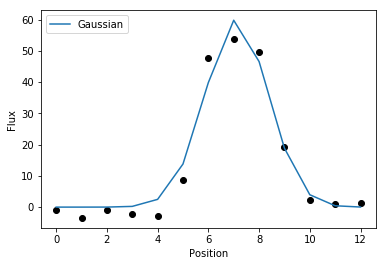

In [21]:
#using this one in for loop but theres still a few randow rows fit doesnt work for

from astropy.modeling import models, fitting
test_row = 162 #162
#69/71, 159/161, 174/176, 183,186 209/211,    still good
#70,160, 175, 184, 185, 205, 210, 219,220,221, 225 bad 

x = ar(range(len(new_short[test_row]))) #independent data, space axis
y = new_short[test_row] #dependent data, flux values at space points



#works if change the amp,mean & std of ginit....but thatll change per row....so how??
g_init = models.Gaussian1D(amplitude=max(y), mean=0, stddev=2.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
print(g)
# Plot the data with the best-fit model
#plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)

In [22]:
g.amplitude #amplitude=35.34540059683567, mean=7.370654092318782, stddev=1.3322034553051836)
g.fwhm

2.9088482089788323

# Applying DS --pix to wl associations for velocity axis (spectral) 

In [23]:
# this applys ds to centroid pix values to get true wl's
centroids_wl = ds_red10.pixtowl(wl_pix_corrected)*u.angstrom

# Converting Pixels --> kpc 

In [24]:
#centering  around core......chose on distance axis for now

#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale
#space_pix_correction2 is row pix of each centroid
#spatial_core_pix is pixel value of the galaxy core in full plate scale


distance_pix_wrtcore = space_pix_correction2 - spatial_core_pix #for core wl using full ccd
distance_pix_wrtcore_sections = space_pix_correction2 - core_from_sections #for core wl using 2 sections around Halpha



In [25]:
#good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []

#below for reference
#distance_pix_wrtcore = space_pix_correction2 - spatial_core_pix


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:#space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    distance = 37*u.Mpc # distance of object from us
    r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc")
    more_sections = r_in_kpc
    distances_sections.append(more_sections)
#another = np.array(another)
distances_sections;

(1395, 1410)

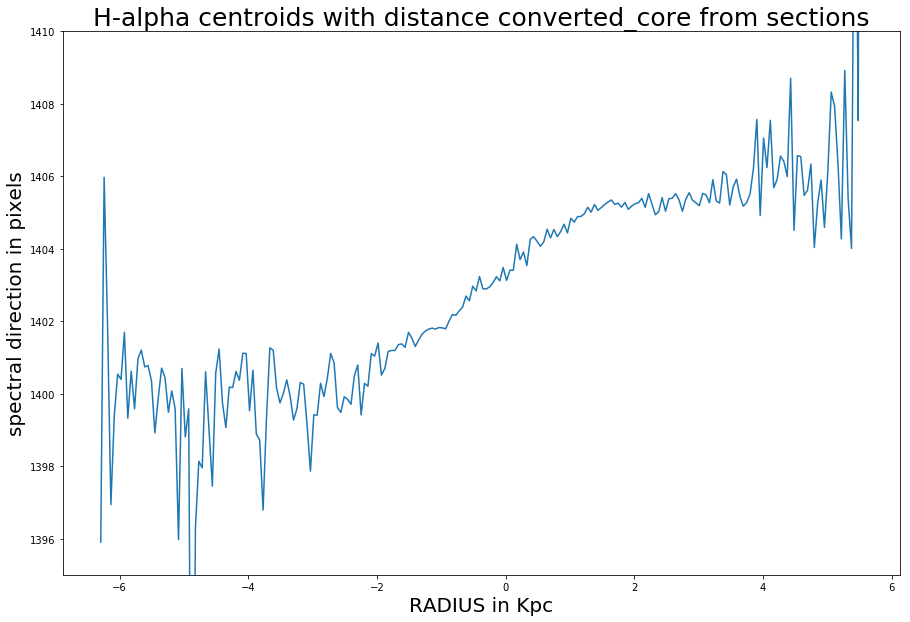

In [26]:
#good for core defined using 2 sections around halpha

plt.figure(figsize=(5,3))

plt.figure(figsize=(15,10))
plt.plot(distances_sections * u.kpc,wl_pix_corrected)
plt.title('H-alpha centroids with distance converted_core from sections',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1395,1410)

# HOST galaxy redshift calculation

In [27]:
#good
#need host z

#calculating z of host
#distance = (c*z)/hubbleconst so need --> (dist * h0) / c = z
distance = 37*u.Mpc #host dist from saga paper
H0 = 70 * u.km / u.s / u.Mpc #hubble const
c = const.c.to('km/s') #speed of light
host_z = (distance * H0)/ c 
host_z_vel = ((distance * H0)/ c ) *c

print('Catch22-host redshift:',host_z)
print('Catch22-host velocity:',host_z_vel)

Catch22-host redshift: 0.00863931006563214
Catch22-host velocity: 2590.0000000000005 km / s


# Core centering

mycore 119
core wl pix value from sections: 1403.47950071


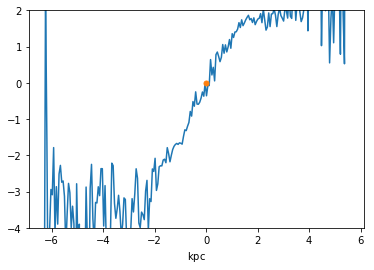

In [28]:
#good for sections defined core
mycore = int(core_from_sections) - 35 #to get acct for target spactial range cut when getting correct core index
print('mycore',mycore)
core_wl_sections = wl_pix_corrected[mycore]
print('core wl pix value from sections:',core_wl_sections)

#making core velocity=0
#relative_tocore_pix = core_wl - wl_pix_corrected #reverse this ie subtract core_wl
relative_tocore_pix_sections = wl_pix_corrected - core_wl_sections# rename as wl_pixshift_wrtcore

#sanity check
plt.plot(u.Quantity(distances_sections), relative_tocore_pix_sections)
#plt.ylim(-8,4) #corepix - centroidpix
plt.ylim(-4,2) #centroidpix - corepix
plt.plot(0,0,'.',markersize=10) #checks center is core

# Converting wl to velocity

In [29]:
velocity_sections = (relative_tocore_pix_sections / core_wl_sections) * c

# ROTATION CURVE

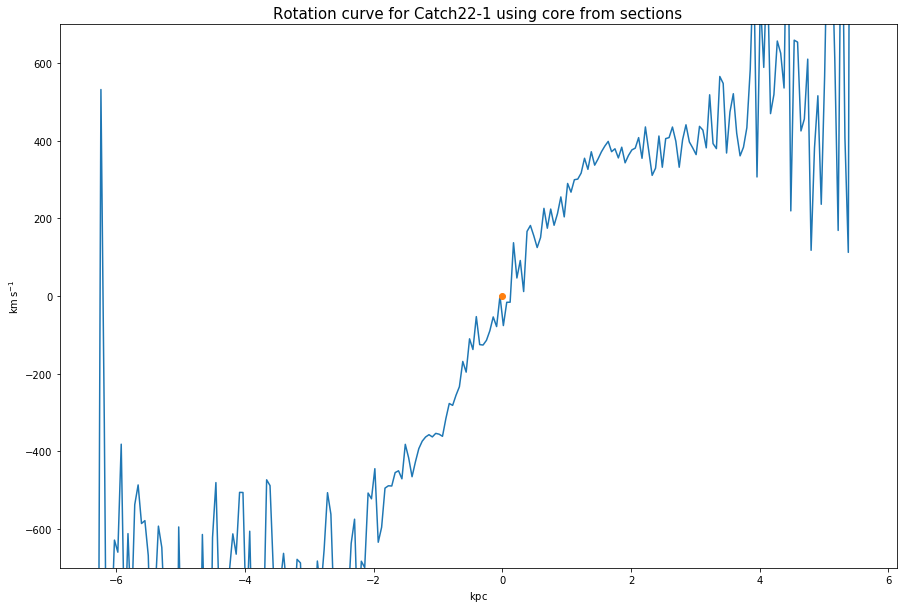

In [30]:
#final product

plt.figure(figsize=(15,10))
plt.plot(u.Quantity(distances_sections), u.Quantity(velocity_sections))
plt.title('Rotation curve for Catch22-1 using core from sections',fontsize=15)
plt.ylim(-700,700)
plt.plot(0,0,'o')

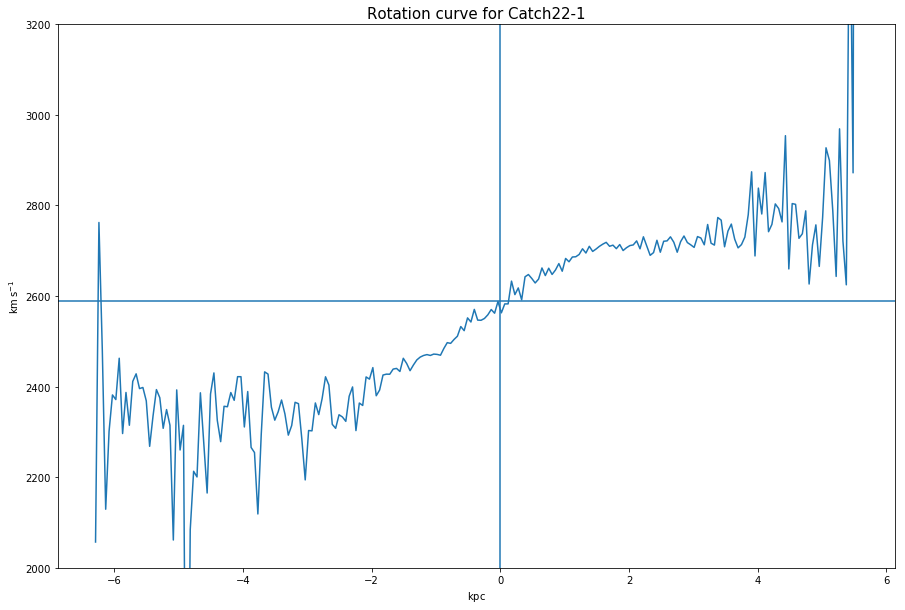

In [31]:
#sanity checks

checking = ds_red10.pixtowl(wl_pix_corrected)*u.angstrom
#checking
velocity = (checking/(6563*u.angstrom)-1) * c


plt.figure(figsize=(15,10))
plt.plot(u.Quantity(distances_sections), u.Quantity(velocity))
plt.title('Rotation curve for Catch22-1',fontsize=15)
plt.axhline(host_z_vel.value)
plt.ylim(2000,3200)
plt.axvline(0)

# Adding Errors to Rotation Curve

In [32]:
#teasing out x & y error arrays from all the gaussian fit data

amps = []
fwhm = []
for row in errors:
    widths = row.fwhm
    fwhm.append(widths)
    amplitudes = row.amplitude
    amps.append(amplitudes)
amps = np.array(amps)
amps = np.reshape(amps, 226)
fwhm = np.array(fwhm)
#print(fwhm)
amps.shape
fwhm.shape

(226,)

# Getting very confused now. Are amps & fwhm still in pixels? Which corresponds to either spatial or spectral axis?
# Is the gauss fit method even right? Get some clarity first

In [33]:
#will look something liek this though


#plt.figure(figsize=(15,10))
#plt.errorbar(u.Quantity(distances_sections), u.Quantitiy(velocity_sections), yerr=fwhm, xerr=amps)
#plt.plot(u.Quantity(distances_sections), u.Quantity(velocity_sections))
#plt.title('Rotation curve for Catch22-1 using core from sections',fontsize=15)
#plt.ylim(-700,700)
#plt.plot(0,0,'o')